In [11]:
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import sys
from PIL import Image, ImageDraw, ImageFont
import json
import cv2
import os
import time
import tensorflow as tf
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.models import load_model
from keras import layers, Input, models, optimizers
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

In [ ]:
# 이전까지 만든 분류 모델 사용할 것
# 새로 crawling 이미지를 가지고 모델을 통해 추천값 matrix 짜기 위한 dataframe 출력
# 동시에 각자 의류 종류, 패턴에 따라 폴더 생성하고 해당되는 이미지 저장 : 나중에 추천시 가져올 수 있게 

In [12]:
# 폴더 생성 함수

def createfolder(foler_dir):
    try:
        if not os.path.exists(folder_dir):
            os.makedirs(folder_dir)
    except OSError:
        print('Error Creating directory'+folder_dir) 

In [63]:
# 자른 이미지 저장할 폴더 생성

#style_list = ['Casual', 'Feminine', 'Formal']
shape_list = ['Hoodie', 'Long-sleeve-tee', 'Shirts', 'Short-sleeve-tee', 'Sweater', 
             'Chiffon-skirt', 'Cotten-long-pants', 'Cutoffs', ' H-line-skirt', 'Jeans']
pattern_list = ['Check', 'Dot', 'Floral', 'Graphic', 'Leopard', 'None', 'Stripe']

for shape in shape_list:
    for pattern in pattern_list:
        folder_name = str(shape +'_'+ pattern)
        folder_dir = str('./img/cropped/' + folder_name)
        createfolder(folder_dir)

In [64]:
# 원피스 사진도 혹시 모르니 저장하는 폴더 생성
pattern_list = ['Check', 'Dot', 'Floral', 'Graphic', 'Leopard', 'None', 'Stripe']

for pattern in pattern_list:
    folder_name = str('One-piece' + '_' + pattern)
    folder_dir = str('./img/cropped/' + folder_name)
    createfolder(folder_dir)

In [48]:
# 전신 이미지 가져와서 상하의 원피스 shape, pattern, style 출력 및 각각 사진 잘라서 저장

def style_shape_pattern(img_dir,                                                      # 이미지 가져오는 주소
                        model_pattern, var_pattern, 
                        model_top, var_top, model_bottom, var_bottom, 
                        model_style, var_style,
                        file_name):                                                    # 이미지 잘라서 저장할 떄 사용할 이름 
    
    # VGG 다운
    conv_base = VGG16(weights = 'imagenet',include_top=False,input_shape=(150,150,3))
    
    # 사용할 model 설정
    model_pattern = load_model(model_pattern)    
#    model_top = load_model(model_top)
    model_bottom = load_model(model_bottom)
    model_style = load_model(model_style)
    
    # 카카오 API 설정
    API_URL = 'https://kapi.kakao.com/v1/vision/product/detect'
    MYAPP_KEY = '7af88d85dc96c6e9ec2ebadca618519a'
    url = "https://kapi.kakao.com/v1/vision/product/detect"       
    headers = {'Authorization': 'KakaoAK {}'.format(MYAPP_KEY)}
    files = { 'file' : open(img_dir, 'rb')}
    response = requests.post(url, headers=headers, files=files)
    
    # 카카오 API 저장 및 예외 상황 설정
    info = []
    result = response.json()
    print(result)
    
    if 'result' in result:                                                    # 카카오API가 이미지 인식 못하는 경우 stop
        fig_w, fig_h = result['result']['width'], result['result']['height']
    else:
        return ['NA','NA','NA','NA','NA','NA','NA']

    if 'objects' in result['result']:
        mylist = result['result']['objects']
        cnt = 0
        for objects in mylist:
            if objects['class'] in ['shirts','t-shirts','pants','outer','skirt','one-piece']:
                cnt = cnt+1
        if cnt > 4:
            return ['NA','NA','NA','NA','NA','NA','NA']
    else:
        return ['NA','NA','NA','NA','NA','NA','NA']
        
    for each in result['result']['objects']:                        
            each = list(each.values())                                            
            info.append(each)
            
    
    # 사진 상하의 구분 및 pattern, shape 예측
    top_pattern = []
    top_shape = []
    bottom_pattern = []
    bottom_shape = []
    one = []
    one_pattern = []
    outer = []
    
    # 사진 전체의 style 예측 
    img = Image.open(img_dir)
    img = img.resize((150,150))
    data = np.array(img)
    data = data.astype('float')
    data = data/255
    data = data.reshape((1,150,150,3))
    st = var_style[model_style.predict_classes(data)[0]]
    style = [st]
     
    
    for _ in range(len(info)):
        img = Image.open(img_dir)
        category = info[_][4]

        if category in ('shirts','t-shirts'):
            if len(top_pattern) == 1 or len(top_shape) == 1:
                pass
            else:
                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5  
                img = img.crop((x,y,w,h))
                cropped_top = img
                
                # 자른 이미지 띄우기
                img.show()
                plt.imshow(img) 
                
                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))
                
                # top pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                top_pattern.append(p)

#                 # top shape 예측
#                 s = conv_base.predict(data)
#                 s = s.reshape((-1,8192))
#                 s = model_top.predict_classes(s)[0]
#                 s = var_top[s]
#                 top_shape.append(s)
                
                # 자른 사진 저장
#                 save_name = str(st + '_' + s + '_' + p + '_' + file_name )
#                 path = str('./img/cropped/' + s + '_' + p + '/')
#                 cropped_top.save( path + save_name )
                 
    
                cropped_top.save(str('./img/cropped/' + file_name))
        
        elif category in ('pants','skirt'): 
            if len(bottom_pattern) == 1 or len(bottom_shape) == 1:
                pass
            else:            
                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5 
                img = img.crop((x,y,w,h))                               
                plt.imshow(img)
                img.show()
                cropped_bottom = img

                # 자른 이미지 띄우기
                img.show()
                plt.imshow(img)    
                
                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))

                # bottom pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                bottom_pattern.append(p)

                # bottom shape 예측
                s = conv_base.predict(data)
                s = s.reshape((-1,8192))
                s = model_bottom.predict_classes(s)[0]
                s = var_bottom[s]
                bottom_shape.append(s)  

                # 자른 이미지 저장
                save_name = str(st + '_' + s + '_' + p + '_' + file_name )
                path = str('./img/cropped/' + s + '_' + p + '/')
                cropped_bottom.save( path + save_name )
        

                
        # 원피스        
        elif category in ('one-piece'):
            one.append('one-piece')
            
            if len(one_pattern) == 1 :
                pass
            else:
                x = info[_][0]*fig_w - 5
                y = info[_][1]*fig_h - 5
                w = info[_][2]*fig_w + 5
                h = info[_][3]*fig_h + 5
                img = img.crop((x,y,w,h))  
                cropped_one = img
                
                # 자른 이미지 띄우기
                img.show()
                plt.imshow(img) 
                
                img = img.resize((150,150))
                data = np.array(img)
                data = data.astype('float')
                data = data/255
                data = data.reshape((1,150,150,3))  

                # one-piece pattern 예측
                p = var_pattern[model_pattern.predict_classes(data)[0]]
                one_pattern.append(p)

                # 자른 이미지 저장 
                save_name = str(st + '_' + s + '_' + p + '_' + file_name )
                path = str('./img/cropped/' + 'One-piece' + '_' + p + '/')
                cropped_one.save( path + save_name )  
                
        # 겉옷       
#         elif category in ('outer'):
#             outer.append('outer')
            
#             if len(outer) == 1 :
#                 pass
#             else:
#                 pass
#                 x = info[_][0]*fig_w - 5
#                 y = info[_][1]*fig_h - 5
#                 w = info[_][2]*fig_w + 5
#                 h = info[_][3]*fig_h + 5
#                 img = img.crop((x,y,w,h))  
#                 cropped_outer = img
                
#                 # 자른 이미지 띄우기
#                 img.show()
#                 plt.imshow(img)             
            
#                 img = img.resize((150,150))
#                 data = np.array(img)
#                 data = data.astype('float')
#                 data = data/255
#                 data = data.reshape((1,150,150,3))


#                 # 자른 이미지 저장 
#                 cropped_outer.save(str('./img/cropped/' + file_name))      
            

    
    # 6)예측값이 없는 경우는 'NA' 값으로 표기
    if len(top_pattern) == 0:
        top_pattern = ['NA']
    if len(top_shape) == 0:
        top_shape = ['NA']        
    if len(bottom_pattern) == 0:
        bottom_pattern = ['NA']
    if len(bottom_shape) == 0:
        bottom_shape = ['NA']
    if len(style) == 0:
        style = ['NA']
    if len(one) == 0:
        one = ['NA']
    if len(one_pattern) == 0:
        one_pattern = ['NA']    
#     if len(outer) == 0:
#         outer =['NA']

    return ( style + top_shape + top_pattern + bottom_shape + bottom_pattern + one + one_pattern  )


['Casual', 'NA', 'None', 'Cutoffs', 'None', 'NA', 'NA', 'NA']

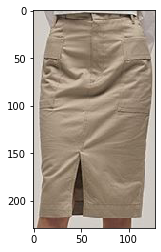

In [50]:
img_dir = './img/recommendation/wusinsa/wusinsa (2).jpg'
model_pattern = './model/pattern_no_camo_정확도76.h5'
var_pattern =  ['Check', 'Dot', 'Floral', 'Graphic', 'Leopard', 'None', 'Stripe']
model_top = './model/upper_9978.h5'
var_top = ['Hoodie', 'Long-sleeve-tee', 'Shirts', 'Short-sleeve-tee', 'Sweater',]
model_bottom = './model/lower0425_9990.h5'
var_bottom = ['Chiffon-skirt', 'Cotten-long-pants', 'Cutoffs', 'H-line-skirt', 'Jeans']
model_style = './model/style_model_1_90,63.h5'
var_style =  ['Casual', 'Feminine', 'Formal']
file_name = 'wusinsa (1).jpg'

style_shape_pattern(img_dir,                                                   
                    model_pattern, var_pattern, 
                    model_top, var_top, model_bottom, var_bottom, 
                    model_style, var_style,
                    file_name)

In [ ]:
['Casual', 'NA', 'Stripe', 'Cutoffs', 'Check', 'NA', 'NA', 'NA']

In [ ]:
def predict_multi(folder_dir,                                                     
                  model_pattern, var_pattern, 
                  model_top, var_top, model_bottom, var_bottom, 
                  model_style, var_style,
                  file_name):
    
    file_list = os.listdir(folder_dir)
    df = pd.DataFrame(index=range(0,0), 
                      columns=['img_dir', 'style', 'top shape', 'top pattern', 'bottom shape', 'bottom pattern',
                               'one-piece','one-piece pattern', 'outer'])
    display(df)
    
    for _ in range(len(file_list)):
        img_dir = folder_dir + '/' + file_list[_]
        Image.open(img_dir)
        
        file_name = file_list[_]
        k = style_shape_pattern(img_dir,                                                     
                                model_pattern, var_pattern, 
                                model_top, var_top, model_bottom, var bottom, 
                                model_shape, var_shape,
                                file_name)   

        # file_name : crop 하기 전 전신 이미지 파일명
        
        total = list(file_name) + k
        df.loc[_] = total
        display(df)
    return df


In [ ]:
img_dir = 
model_pattern = 
var_pattern = 
model_top = 
var_top = 
model_bottom =
var bottom = 
model_shape =
var_shape =
file_name =


predict_multi(folder_dir,                                                     
                  model_pattern, var_pattern, 
                  model_top, var_top, model_bottom, var bottom, 
                  model_shape, var_shape,
                  file_name)

In [ ]:
folder_dir = 'C:/Jupyter_Script/final_project/img/pattern/leopard'

model_pattern = './model/pattern_no_camo_정확도76.h5'
var_pattern = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe', 'tribal']  

model_style = './model/model_style_3개_90%_63%.h5'
var_style = ['casual', 'feminine', 'formal']

model_shape = './model/clothes_category_83%.h5'
var_shape = ['Coat','Cutoffs','Hoodie','Jacket','Jeans','Poncho','Sarong','Shirt','Skirt','Sweater','Tee']


df = predict_multi(folder_dir, 
              model_pattern, var_pattern, 
              model_style, var_style, 
              model_shape, var_shape) 


In [ ]:
df.to_csv('test.csv')

In [60]:
q = os.listdir('./img/etc/')

In [61]:
q

[' H-line-skirt_Check',
 ' H-line-skirt_Dot',
 ' H-line-skirt_Floral',
 ' H-line-skirt_Graphic',
 ' H-line-skirt_Leopard',
 ' H-line-skirt_None',
 ' H-line-skirt_Stripe',
 'Chiffon-skirt_Check',
 'Chiffon-skirt_Dot',
 'Chiffon-skirt_Floral',
 'Chiffon-skirt_Graphic',
 'Chiffon-skirt_Leopard',
 'Chiffon-skirt_None',
 'Chiffon-skirt_Stripe',
 'Cotten-long-pants_Check',
 'Cotten-long-pants_Dot',
 'Cotten-long-pants_Floral',
 'Cotten-long-pants_Graphic',
 'Cotten-long-pants_Leopard',
 'Cotten-long-pants_None',
 'Cotten-long-pants_Stripe',
 'Cutoffs_Check',
 'Cutoffs_Dot',
 'Cutoffs_Floral',
 'Cutoffs_Graphic',
 'Cutoffs_Leopard',
 'Cutoffs_None',
 'Cutoffs_Stripe',
 'Hoodie_Dot',
 'Hoodie_Graphic',
 'Hoodie_None',
 'Hoodie_Stripe',
 'Jeans_Check',
 'Jeans_Dot',
 'Jeans_Floral',
 'Jeans_Graphic',
 'Jeans_Leopard',
 'Jeans_None',
 'Jeans_Stripe',
 'Long-sleeve-tee_Check',
 'Long-sleeve-tee_Dot',
 'Long-sleeve-tee_Floral',
 'Long-sleeve-tee_Graphic',
 'Long-sleeve-tee_Leopard',
 'Long-sleeve-

In [ ]:
## 오류나는 사진 (한 장) 확인용

img_dir = 'C:/python_DA/final_project/img/추천용/새 폴더/체크 코디원본s33.jpg'
model_pattern = 'pattern_7class_정확도77.h5'
var_pattern = ['check', 'dot', 'floral', 'graphic', 'leopard', 'none', 'stripe']  

model_style = './model/model_style_3개_90%_63%.h5'
var_style = ['casual', 'feminine', 'formal']

model_shape = './model/clothes_category_83%.h5'
var_shape = ['Coat','Cutoffs','Hoodie','Jacket','Jeans','Poncho','Sarong','Shirt','Skirt','Sweater','Tee']


file_name = '체크 코디원본s33.jpg'
style_n_pattern(img_dir, model_pattern, var_pattern, model_style, var_style, 
                model_shape, var_shape, file_name)